In [58]:
from helpers import *
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries to create the multiclass model
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
#Import tensorflow and disable the v2 behavior and eager mode
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

#Library to validate the model
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

In [59]:
df = pd.read_csv("data_moods.csv")

In [60]:
col_features = df.columns[6:-3]
X= MinMaxScaler().fit_transform(df[col_features])
X2 = np.array(df[col_features])
Y = df['mood']

In [61]:
encoder = LabelEncoder()
encoder.fit(Y)
encoded_y = encoder.transform(Y)


#Convert to  dummy (Not necessary in my case)
dummy_y = np_utils.to_categorical(encoded_y)

X_train,X_test,Y_train,Y_test = train_test_split(X,encoded_y,test_size=0.2,random_state=15)

target = pd.DataFrame({'mood':df['mood'].tolist(),'encode':encoded_y}).drop_duplicates().sort_values(['encode'],ascending=True)
target

,mood,encode
5,Calm,0
4,Energetic,1
0,Happy,2
1,Sad,3


In [62]:
def base_model():
    #Create the model
    model = Sequential()
    #Add 1 layer with 8 nodes,input of 4 dim with relu function
    model.add(Dense(8,input_dim=10,activation='relu'))
    #Add 1 layer with output 3 and softmax function
    model.add(Dense(4,activation='softmax'))
    #Compile the model using sigmoid loss function and adam optim
    model.compile(loss='categorical_crossentropy',optimizer='adam',
                 metrics=['accuracy'])
    return model

In [63]:
estimator = KerasClassifier(build_fn=base_model,epochs=300,batch_size=200,verbose=0)


In [64]:
#Evaluate the model using KFold cross validation
kfold = KFold(n_splits=10,shuffle=True)
results = cross_val_score(estimator,X,encoded_y,cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100,results.std()*100))

Baseline: 79.31% (3.82%)


In [65]:
estimator.fit(X_train,Y_train)
y_preds = estimator.predict(X_test)

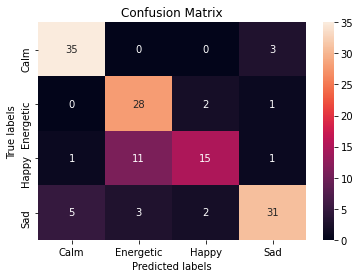

Accuracy Score 0.7898550724637681


In [66]:
cm = confusion_matrix(Y_test,y_preds)
ax = plt.subplot()
sns.heatmap(cm,annot=True,ax=ax)

labels = target['mood']
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

print("Accuracy Score",accuracy_score(Y_test,y_preds))

In [67]:
# Create your developer account and get credentails from - https://developer.spotify.com/
import spotipy
import time
from IPython.core.display import clear_output
from spotipy import SpotifyClientCredentials, util

client_id='xxxxxxx'
client_secret='xxxxxx'
# redirect_uri='your_url_to_redirect'
# username = 'your_username_spotify_code'
# scope = 'playlist-modify-public'

#Credentials to access the Spotify Music Data
manager = SpotifyClientCredentials(client_id,client_secret)
sp = spotipy.Spotify(client_credentials_manager=manager)

In [68]:
def get_songs_features(ids):

    meta = sp.track(ids)
    features = sp.audio_features(ids)

    # meta
    name = meta['name']
    album = meta['album']['name']
    artist = meta['album']['artists'][0]['name']
    release_date = meta['album']['release_date']
    length = meta['duration_ms']
    popularity = meta['popularity']
    ids =  meta['id']

    # features
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    liveness = features[0]['liveness']
    valence = features[0]['valence']
    loudness = features[0]['loudness']
    speechiness = features[0]['speechiness']
    tempo = features[0]['tempo']
    key = features[0]['key']
    time_signature = features[0]['time_signature']

    track = [name, album, artist, ids, release_date, popularity, length, danceability, acousticness,
            energy, instrumentalness, liveness, valence, loudness, speechiness, tempo, key, time_signature]
    columns = ['name','album','artist','id','release_date','popularity','length','danceability','acousticness','energy','instrumentalness',
                'liveness','valence','loudness','speechiness','tempo','key','time_signature']
    return track,columns

In [69]:
# function that can predict mood of song Id.
# Ex: SongId: https://open.spotify.com/track/54bFM56PmE4YLRnqpW6Tha

def predict_mood(id_song):
    #Join the model and the scaler in a Pipeline
    pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
                                                                             batch_size=200,verbose=0))])
    #Fit the Pipeline
    pip.fit(X2,encoded_y)

    #Obtain the features of the song
    preds = get_songs_features(id_song)
    #Pre-process the features to input the Model
    preds_features = np.array(preds[0][6:-2]).reshape(-1,1).T

    #Predict the features of the song
    results = pip.predict(preds_features)

    mood = np.array(target['mood'][target['encode']==int(results)])
    name_song = preds[0][0]
    artist = preds[0][2]

    return print("{0} by {1} is a {2} song".format(name_song,artist,mood[0].upper()))
    #print(f"{name_song} by {artist} is a {mood[0].upper()} song")

In [70]:
predict_mood('54bFM56PmE4YLRnqpW6Tha')

Therefore I Am by Billie Eilish is a HAPPY song


In [71]:
#  
# Ex: Spotify artist - https://open.spotify.com/artist/4q3ewBCX7sLwd24euuV69X

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

lz_uri = 'spotify:artist:4q3ewBCX7sLwd24euuV69X'

spotify = spotipy.Spotify(client_credentials_manager=manager)
results = spotify.artist_top_tracks(lz_uri)

for track in results['tracks'][:10]:
    print('track    : ' + track['name'])
    print('trackId   : ' + track['id'])
    preview_url = track['preview_url']
    if preview_url is None:
        preview_url = 'Not Available..'
    print('audio    : ' + preview_url)
    print('cover art: ' + track['album']['images'][0]['url'])
    print()

track    : Dakiti
trackId   : 47EiUVwUp4C9fGccaPuUCS
audio    : https://p.scdn.co/mp3-preview/edd9bea2e66b14169f8bbfa45a78b6599b14160a?cid=9ba8560ce44540a8a907412d26cedc64
cover art: https://i.scdn.co/image/ab67616d0000b27334c8199b0b3b3fb42b8a98a8

track    : UN DIA (ONE DAY) (Feat. Tainy)
trackId   : 0EhpEsp4L0oRGM0vmeaN5e
audio    : Not Available..
cover art: https://i.scdn.co/image/ab67616d0000b273312bd86cc2db22fde885ee73

track    : Hasta Que Dios Diga
trackId   : 06s3QtMJVXw1AJX3UfvZG1
audio    : https://p.scdn.co/mp3-preview/0ab6784a19b1aaae24a7765085d9ff93a6e8274a?cid=9ba8560ce44540a8a907412d26cedc64
cover art: https://i.scdn.co/image/ab67616d0000b2733cb695bfc1246bdf66161fce

track    : Safaera
trackId   : 2DEZmgHKAvm41k4J3R2E9Y
audio    : https://p.scdn.co/mp3-preview/c67f59e5d3806b41f54f772ba8cc24410ed0a258?cid=9ba8560ce44540a8a907412d26cedc64
cover art: https://i.scdn.co/image/ab67616d0000b273548f7ec52da7313de0c5e4a0

track    : Yo Perreo Sola
trackId   : 0SqqAgdovOE24BzxIClp

In [72]:
# Get details for given playlist.
# Ex: Top 50 playlist - https://open.spotify.com/playlist/37i9dQZEVXbLRQDuF5jeBp

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# 44tRfteJJzAmUONSiA56bQ

# 37i9dQZEVXbLRQDuF5jeBp - top 50 playlist

spotify = spotipy.Spotify(client_credentials_manager=manager)
results = spotify.playlist('44tRfteJJzAmUONSiA56bQ')

for item in results['tracks']['items']:
    trackId = item['track']['id']
    print('track Id    : ' + trackId)
    trackName = item['track']['name']
    print('track Name   : ' + trackName)
    preview_url = item['track']['preview_url']
    if preview_url is None:
        preview_url = ''
    print('audio    : ' + preview_url)
    print()


track Id    : 7m9OqQk4RVRkw9JJdeAw96
track Name   : Jocelyn Flores
audio    : https://p.scdn.co/mp3-preview/9fd5ccc86f318c303d582800e9f7d6f07f40440b?cid=9ba8560ce44540a8a907412d26cedc64

track Id    : 43zdsphuZLzwA9k4DJhU0I
track Name   : when the party's over
audio    : 

track Id    : 2RttW7RAu5nOAfq6YFvApB
track Name   : Happier
audio    : https://p.scdn.co/mp3-preview/e2f5edb569c73916428ec0a2e0b56a9f777851dd?cid=9ba8560ce44540a8a907412d26cedc64

track Id    : 5qrSlOut2rNAWv3ubArkNy
track Name   : Be Alright
audio    : 

track Id    : 4kflIGfjdZJW4ot2ioixTB
track Name   : Someone Like You
audio    : https://p.scdn.co/mp3-preview/d808ccb1a59c5f21a14cf8da9974558f84366933?cid=9ba8560ce44540a8a907412d26cedc64

track Id    : 5tz69p7tJuGPeMGwNTxYuV
track Name   : 1-800-273-8255
audio    : 

track Id    : 6y6jbcPG4Yn3Du4moXaenr
track Name   : idfc
audio    : https://p.scdn.co/mp3-preview/80f59f57f6d2e9fac6c06273954cad289724caf5?cid=9ba8560ce44540a8a907412d26cedc64

track Id    : 4ZLzoOkj0M